In [1]:
# def old_HOG(image, cell_size=(8, 8), block_size=(2, 2), bins=9):
#     # Chia ảnh thành các ô
#     h, w = image.shape
#     cells_x = w // cell_size[1]
#     cells_y = h // cell_size[0]
    
#     # Tính toán histogram cho mỗi ô
#     hist = np.zeros((cells_y, cells_x, bins), dtype=np.float32)
#     for i in range(cells_y):
#         for j in range(cells_x):
#             cell = image[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
#             hist[i, j] = np.histogram(cell, bins=bins, range=(0, 180))[0]

#     # Chuẩn hóa histogram cho mỗi khối
#     hog_features = []
#     for i in range(cells_y - block_size[0] + 1):
#         for j in range(cells_x - block_size[1] + 1):
#             block = hist[i:i+block_size[0], j:j+block_size[1]].flatten()
#             norm_block = block / np.linalg.norm(block) if np.linalg.norm(block) > 0 else block
#             hog_features.append(norm_block)

#     return np.array(hog_features).flatten()

## Human Detection 

# GetData

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
DataPath = 'Dataset/210417_MtErie_Enterprise_VIS_0003'
DataPath2 = 'Dataset/210417_MtErie_Enterprise_IR_0004'
def GetData(path):
    imgs = []
    labelbox = []
    for file in os.listdir(path):
        if file.split('.')[-1] == 'jpeg':
            imgs.append(os.path.join(path, file))
        else:
            labelbox.append(os.path.join(path, file))
    return imgs, labelbox

In [3]:
imgs1, label1 = GetData(DataPath)
imgs2, label2 = GetData(DataPath2)
imgs = imgs1 + imgs2
label = label1 + label2

In [4]:
len(imgs), len(label)

(528, 530)

# Drawing boundingbox for data train

In [5]:
def GetImgs(imgs = imgs):
    data = []
    for img in imgs:
        image = cv2.imread(img)
        image = cv2.resize(image,(640,640))
        data.append(image)
    return data

In [6]:
def GetLabelCoord(labelbox):
    labels = []
    for file in labelbox:
        with open(file, 'r') as f:
            lines = f.readlines()
            temp = []
            for line in lines:
                line = line.strip()
                temp.append((line.split(' ')[1:]))
            labels.append(temp)
            temp = []
    return labels

In [7]:
def GetImgsBB(data, label = label):
    data_cp = []
    bboxes = []
    labelsCoord = GetLabelCoord(label)
    for index, image in enumerate(data):
        height, width = image.shape[0], image.shape[1]
        temp = []
        image_copy = image.copy()
        for bbox in labelsCoord[index]:
            if len(bbox) >= 4:
                x_center, y_center, w, h = (float(bbox[0])*width, float(bbox[1])*height, float(bbox[2])*width, float(bbox[3])*height)
                x_min = int(x_center - w/2)
                y_min = int(y_center - h/2)
                x_max = int(x_center + w/2)
                y_max = int(y_center + h/2)
                temp.append((x_min, y_min, x_max, y_max))
                cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=10)
        bboxes.append(temp)
        data_cp.append(image_copy)
    return data_cp, bboxes
                    

        

In [8]:
data = GetImgs()

In [9]:
data__bb, bboxes = GetImgsBB(data)

In [10]:
len(data[0])

640

In [11]:
len(data__bb), len(bboxes)

(528, 528)

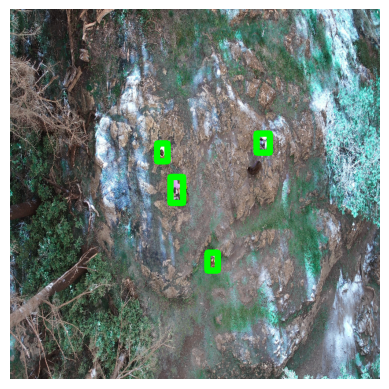

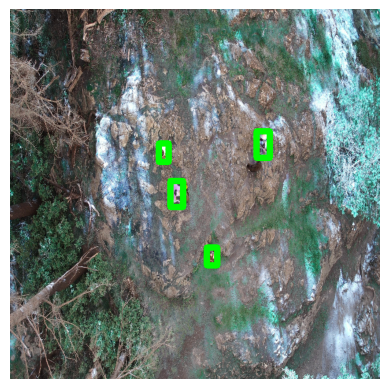

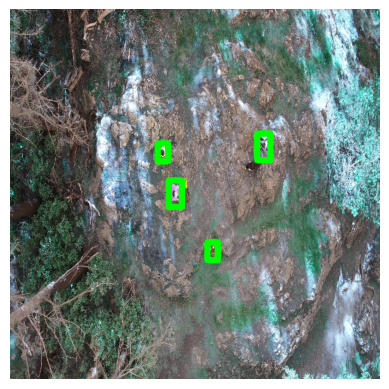

In [12]:
for img in data__bb[:3]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Get the cropped Image for model

In [23]:
def CropImg(imgs, bboxes):
    crops = []
    for index, img in enumerate(imgs):
        for bbox in bboxes[index]:
            x_min, y_min, x_max, y_max = bbox
            crop = img[y_min:y_max, x_min:x_max]
            crops.append(crop)
    return crops

In [14]:
data_crop = CropImg(data, bboxes)

In [15]:
len(data_crop)

2024

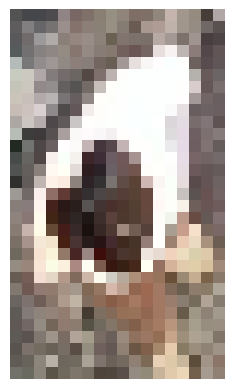

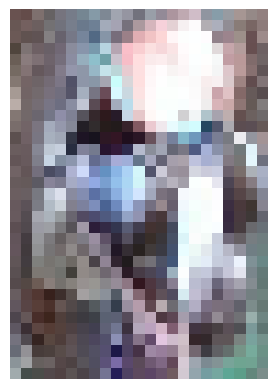

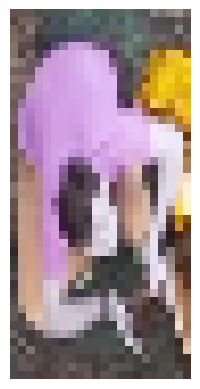

In [16]:
for img in data_crop[:3]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

non-human label

In [17]:
def CheckOverlayBB(crops, bboxes):
    x_min_crop, y_min_crop, x_max_crop, y_max_crop = crops
    for bbox in bboxes:
        x_min_box, y_min_box, x_max_box, y_max_box = bbox
        if (x_max_crop >= x_min_box and x_min_crop <= x_max_box and 
            y_max_crop >= y_min_box and y_min_crop <= y_max_box):
            return False
    return True


In [18]:
def GetImgsBBNonHuman(data, bboxes_crop, num_samples=4, min_size=40, max_size=80):
    random_bbs = []
    for index, img in enumerate(data):
        height, width = img.shape[0], img.shape[1]
        temp = []
        i = 1
        while (i<=num_samples):
            x_min = random.randint(0, width - 40)
            y_min = random.randint(0, height - 40)
            x_max = random.randint(x_min + 40, 
                                   width if (x_min + min_size + max_size) > width else x_min + min_size + max_size)
            y_max = random.randint(y_min + 40, 
                                   height if (y_min + min_size + max_size) > height else y_min + min_size + max_size)
            if CheckOverlayBB((x_min, y_min, x_max, y_max), bboxes_crop[index]):
                temp.append((x_min, y_min, x_max, y_max))
                i+=1
        random_bbs.append(temp)
    return random_bbs

In [19]:
random_bbs_non_human = GetImgsBBNonHuman(data, bboxes)

In [20]:
len(random_bbs_non_human)

528

In [21]:
data_non_human = CropImg(data, random_bbs_non_human)

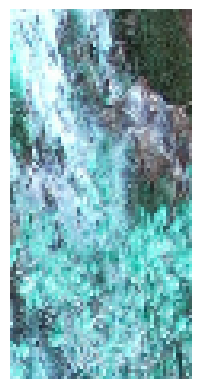

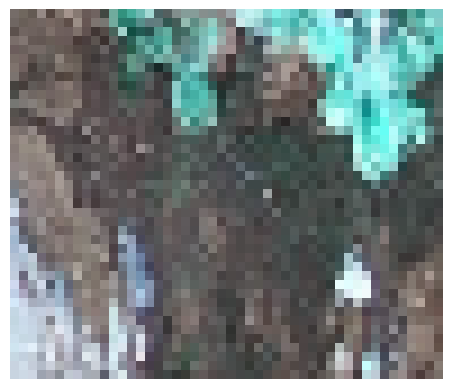

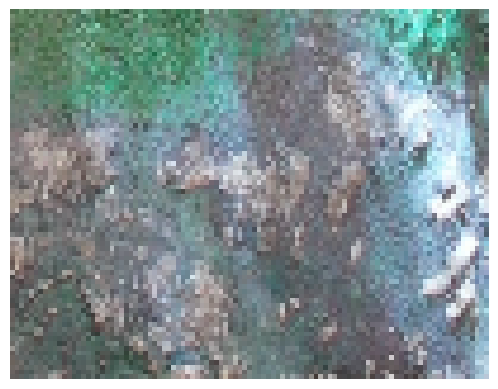

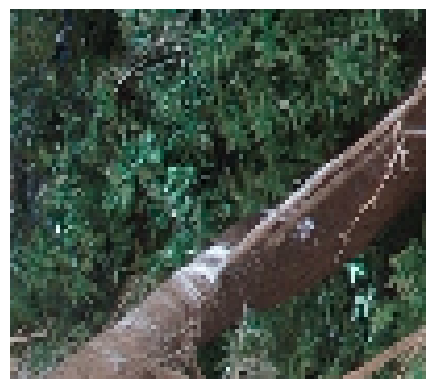

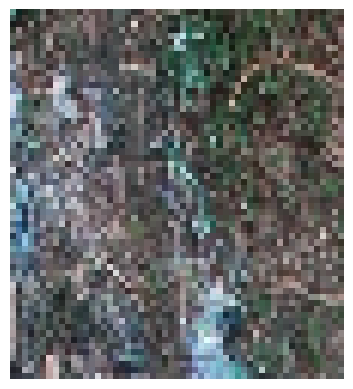

In [22]:
for img in data_non_human[:5]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [24]:
len(data_non_human), len(data_crop)

(2112, 2024)

In [25]:
data_non_human[0].shape, data_crop[0].shape

((116, 57, 3), (31, 18, 3))

In [26]:
label = len(data_non_human)* [0] + len(data_crop)*[1]
label = np.array(label)

data_combined = data_non_human + data_crop
len(data_combined),len(label)

(4136, 4136)

## PREPROCESSING

1. Resize image

In [27]:
for index,val in enumerate(data_combined):
    val = cv2.cvtColor(val, cv2.COLOR_RGB2GRAY)
    data_combined[index] = cv2.resize(val, (64, 64))

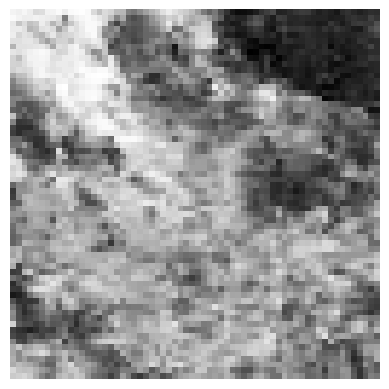

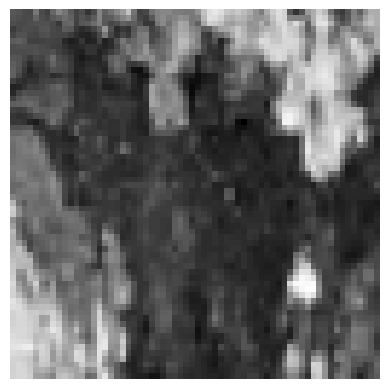

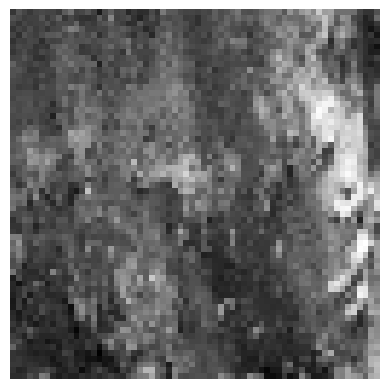

In [28]:
for img in data_combined[:3]:
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

2. Normalization

In [29]:
data_combined[0]

array([[243, 239, 245, ...,  67,  73,  72],
       [248, 243, 237, ...,  72,  88,  79],
       [233, 203, 222, ...,  82,  82, 102],
       ...,
       [180, 194, 185, ..., 158, 134, 108],
       [218, 201, 197, ..., 113, 132, 114],
       [207, 211, 217, ..., 108, 143, 136]], dtype=uint8)

In [30]:
def NormalizeData(data_combined):
    data = []
    for img in data_combined:
        img = cv2.resize(img, (64, 64))
        data.append(img)
    return data

In [31]:
data_normalize = NormalizeData(data_combined)

In [32]:
data_normalize[0]

array([[243, 239, 245, ...,  67,  73,  72],
       [248, 243, 237, ...,  72,  88,  79],
       [233, 203, 222, ...,  82,  82, 102],
       ...,
       [180, 194, 185, ..., 158, 134, 108],
       [218, 201, 197, ..., 113, 132, 114],
       [207, 211, 217, ..., 108, 143, 136]], dtype=uint8)

## MODEL

1. HOG

In [33]:
def padding(img_pre):
    img_pad = np.zeros((img_pre.shape[0] + 2, img_pre.shape[1] + 2), dtype=np.float32)
    img_pad[1:-1, 1:-1] = img_pre
    img_pad[0,1:-1] = img_pre[0,:] # paddign trên
    img_pad[-1,1:-1] = img_pre[-1,:] # padding dưới
    img_pad[1:-1,0] = img_pre[:,0] # padding trái
    img_pad[1:-1,-1] = img_pre[:,-1] # padding phải
    img_pad[0,0] = img_pre[0,0] # padding trên trái
    img_pad[0,-1] = img_pre[0,-1] # padding trên phải
    img_pad[-1,0] = img_pre[-1,0] # padding dưới trái
    img_pad[-1,-1] = img_pre[-1,-1] # padding dưới phải
    return img_pad

In [34]:
def Gradient(img_pre):
    h, w = img_pre.shape
    img_pad = padding(img_pre)
    gradient_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gradient_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    img_gradient_direction = np.zeros((h, w), dtype=np.float32)
    img_gradient_magnitude = np.zeros((h, w), dtype=np.float32)
    img_cp = np.zeros((3, 3), dtype=np.float32)
    for i in range(1,h+1):
        for j in range(1,w+1):
            img_cp = img_pad[i-1:i+2, j-1:j+2] # Th binh thuong
            gradient_x_value = np.sum(img_cp * gradient_x)
            gradient_y_value = np.sum(img_cp * gradient_y)
            img_gradient_direction[i-1, j-1] = abs(np.arctan2(gradient_y_value, gradient_x_value) * 180 / np.pi)
            img_gradient_magnitude[i-1, j-1] = np.sqrt(gradient_x_value**2 + gradient_y_value**2)
            
    return img_gradient_direction, img_gradient_magnitude

In [35]:
data_gradient_direction, data_gradient_magnitude = Gradient(data_normalize[0])
data_gradient_direction.shape, data_gradient_magnitude.shape

((64, 64), (64, 64))

In [36]:
def Histogram(img_gradient_direction, img_gradient_magnitude, bins=9):
    h, w = img_gradient_direction.shape
    bin_width = 180 / bins
    histogram = np.zeros((bins), dtype=np.float32)
    for i in range(h):
        for j in range(w):
            index = np.floor(img_gradient_direction[i, j] / 180 * bins).astype(int)
            left_affect = (bin_width*(index+1)-img_gradient_direction[i, j]) / bin_width
            right_affect = (img_gradient_direction[i, j]-bin_width*index) / bin_width
            histogram[index%bins] += img_gradient_magnitude[i, j] * left_affect
            histogram[(index+1)%bins] += img_gradient_magnitude[i, j] * right_affect
    return histogram

In [37]:
def HOG(data_direction, data_magnitude, cell_size=(8, 8), block_size=(2, 2), bins=9):
    h, w = data_direction.shape
    cells_x = w // cell_size[1]
    cells_y = h // cell_size[0]
    
    hist = np.zeros((cells_y, cells_x, bins), dtype=np.float32)
    for i in range(cells_y):
        for j in range(cells_x):
            cell_dir = data_direction[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            cell_mag = data_magnitude[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            hist[i, j] = Histogram(cell_dir, cell_mag, bins=bins)

    hog_features = []
    for i in range(cells_y - block_size[0] + 1):
        for j in range(cells_x - block_size[1] + 1):
            block = hist[i:i+block_size[0], j:j+block_size[1]].flatten()
            norm_block = block / np.linalg.norm(block) if np.linalg.norm(block) > 0 else block
            hog_features.append(norm_block)

    return np.array(hog_features).flatten()

In [38]:
hog_result = HOG(data_gradient_direction, data_gradient_magnitude)
hog_result

array([0.04038626, 0.04741596, 0.10265603, ..., 0.07967053, 0.04584508,
       0.15926048], dtype=float32)

In [39]:
def DataHOG(data_normalize):
    hog_features = []
    for img in data_normalize:
        img_gradient_direction, img_gradient_magnitude = Gradient(img)
        hog_feature = HOG(img_gradient_direction, img_gradient_magnitude)
        hog_features.append(hog_feature)
    return np.array(hog_features)


In [40]:
data_HOG = DataHOG(data_normalize)
data_HOG.shape, label.shape

((4136, 1764), (4136,))

# SVM

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

model_detect_human = SVC()
x_train, x_test, y_train, y_test = train_test_split(data_HOG, label, shuffle=True, test_size=0.2)
model_detect_human.probability=True
model_detect_human.fit(x_train, y_train)
y_pred = model_detect_human.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       431
           1       0.97      0.98      0.97       397

    accuracy                           0.97       828
   macro avg       0.97      0.97      0.97       828
weighted avg       0.97      0.97      0.97       828



In [67]:
prob =model_detect_human.predict_proba([x_test[200]])
print(prob)
if prob.argmax(axis=1)==1 and prob.max(1)>0.99:
    print(True)

[[0.00887688 0.99112312]]
True


# Detect

In [44]:
def NormalizeImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (64, 64))
    return image


In [45]:
def SlidingWindow(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size[1]):
        for x in range(0, image.shape[1] - window_size[0], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [46]:
def DetectHuman(image, model):
    image = NormalizeImage(image)
    img_direction, img_magnitude = Gradient(image)
    hog_features = HOG(img_direction, img_magnitude)
    hog_features = hog_features.reshape(1, -1)
    prediction = model.predict_proba(hog_features)
    return prediction


In [143]:
def BoundingBox(image, model, step_size=(10, 10), window_size=(20, 20)):
    bboxes = []
    for (x,y,image) in SlidingWindow(image, step_size, window_size):
        prob= DetectHuman(image, model)
        if prob.argmax(axis=1)==1 and prob.max(1) >=0.9:
            print(x, y, x + window_size[0], y + window_size[1])
            bboxes.append((x, y, x + window_size[0], y + window_size[1])) #(x_min, y_min, x_max, y_max)
    return bboxes

In [48]:
def DrawBBox(image, bboxes):
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
    return image

120 20 140 40
130 20 150 40
140 20 160 40
140 170 160 190
430 210 450 230
250 230 270 250
280 290 300 310
110 430 130 450
120 430 140 450
100 440 120 460
120 440 140 460
470 490 490 510
450 580 470 600


(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

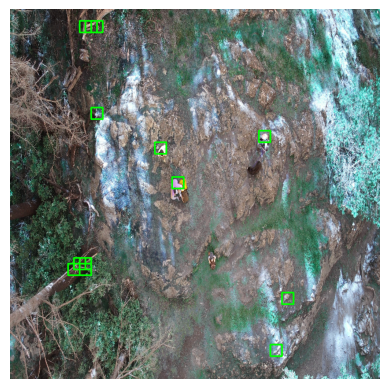

In [144]:
test = cv2.imread(imgs[0])
test= cv2.resize(test,(640,640))
bboxes = BoundingBox(test, model_detect_human)
test_with_bboxes = DrawBBox(test, bboxes)
plt.imshow(test_with_bboxes)
plt.axis('off')